In [185]:
# Nhập tất cả các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string
import re
import nltk
from nltk.corpus import stopwords as StopWords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [186]:
data = pd.read_csv("HCM_Reviews.csv")

# Data Preprocessing

In [187]:
data = data.dropna()
# Bỏ các hàng trùng lặp
data.drop_duplicates(inplace=True)

In [188]:
data.head(5)

,Hcomment,Date of stay,Rating
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,5.0
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,5.0
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,5.0
6,Very very friendly and efficient staff … loved...,Date of stay: November 2021,5.0
8,Exceptional property. Just great experience. V...,Date of stay: October 2021,5.0


In [189]:
# Kiểm tra thông tin cho tập dữ liệu sau khi loại bỏ các hàng giá trị rỗng và các hàng trùng lặp
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12796 entries, 0 to 30390
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hcomment      12796 non-null  object 
 1   Date of stay  12796 non-null  object 
 2   Rating        12796 non-null  float64
dtypes: float64(1), object(2)
memory usage: 399.9+ KB


In [190]:
# Kiểm tra phần trăm hàng cho mỗi xếp hạng
data["Rating"].value_counts(normalize = True)

5.0    0.761175
4.0    0.155048
3.0    0.043295
1.0    0.024695
2.0    0.015786
Name: Rating, dtype: float64

In [191]:
# Ánh xạ tích cực, trung tính và tiêu cực với các giá trị xếp hạng
data["Sentiment"] = data["Rating"].replace(to_replace=[1,2,3,4,5], value=["Negative","Negative","Neutral","Positive","Positive"])

In [192]:
# Tạo cột năm lưu trú mới từ ngày lưu trú của cột hiện có của chúng tôi
data["Year of stay"] = data["Date of stay"].apply(lambda x: "".join(re.findall("\d\d\d\d", x)))
data

,Hcomment,Date of stay,Rating,Sentiment,Year of stay
0,Most beautiful stay at Mussoorie...such a gorg...,Date of stay: August 2021,5.0,Positive,2021
2,The Savoy is one of those rare hotels that not...,Date of stay: October 2020,5.0,Positive,2020
4,Def Best stay in Uttarakand ! Amazing nature. ...,Date of stay: November 2021,5.0,Positive,2021
6,Very very friendly and efficient staff … loved...,Date of stay: November 2021,5.0,Positive,2021
8,Exceptional property. Just great experience. V...,Date of stay: October 2021,5.0,Positive,2021
...,...,...,...,...,...
30382,I stayed in this hotel with my 5 family member...,Date of stay: May 2008,4.0,Positive,2008
30384,the best histrocally place in india,Date of stay: April 2007,5.0,Positive,2007
30386,It was a wonderful experience in Mussoorie. Gr...,Date of stay: May 2009,4.0,Positive,2009
30388,Sterling Resort at the first look doesnt seem ...,Date of stay: April 2009,4.0,Positive,2009


In [193]:
# Tạo cột tháng lưu trú từ cột ngày lưu trú
data["Month of stay"] = data["Date of stay"].apply(lambda x: "".join(re.findall(r'(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)', x)))
data.drop(['Date of stay'], axis=1, inplace=True)
data

,Hcomment,Rating,Sentiment,Year of stay,Month of stay
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October
...,...,...,...,...,...
30382,I stayed in this hotel with my 5 family member...,4.0,Positive,2008,May
30384,the best histrocally place in india,5.0,Positive,2007,April
30386,It was a wonderful experience in Mussoorie. Gr...,4.0,Positive,2009,May
30388,Sterling Resort at the first look doesnt seem ...,4.0,Positive,2009,April


In [194]:
# Bỏ tất cả các hàng cho năm nào nhỏ hơn 2018
data.drop(data[data["Year of stay"] < '2018'].index, axis=0, inplace=True)

# Bỏ tất cả các hàng tình cảm trung lập
data.drop(data[data["Sentiment"] == "Neutral"].index, axis=0, inplace=True)

In [195]:
# Kiểm tra thông tin cho tập dữ liệu sau khi loại bỏ các hàng
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8293 entries, 0 to 29156
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Hcomment       8293 non-null   object 
 1   Rating         8293 non-null   float64
 2   Sentiment      8293 non-null   object 
 3   Year of stay   8293 non-null   object 
 4   Month of stay  8293 non-null   object 
dtypes: float64(1), object(4)
memory usage: 388.7+ KB


In [196]:
# Kiểm tra tỷ lệ phần trăm của mỗi ý kiến trong tập dữ liệu của chúng tôi
data.Sentiment.value_counts(normalize=True)

Positive    0.974195
Negative    0.025805
Name: Sentiment, dtype: float64

In [197]:
# Tạo một hàm để xử lý trước dữ liệu
def preprocess_data(text):
    """
    Returns text after removing numbers, punctuations, urls, emojis, html tags and lowercasing all the words in given text.
    """
    text = re.sub(r'[0-9]+', '', str(text))   # removing numbers
    text = re.sub(r'[^\w\s]', '', str(text))   # removing punctuations
    text = " ".join(x.lower() for x in text.split())  # lower casing the text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # removing urls
    text = re.sub(r'<.*?>', '', text) # removing html tags
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(x for x in text.split() if x not in StopWords.words('english'))
    return text

In [198]:
# Áp dụng chức năng preprocess_data cho cột đánh giá
data["Preprocessed_reviews"] = data["Hcomment"].apply(lambda x: preprocess_data(x))

data.head()

,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...


In [199]:
# Tạo cột cho số từ trong bài đánh giá

# Word count
data["Word_count"] = data["Hcomment"].apply(lambda x: len(str(x).split()))
data.head()

,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...,134
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...,197
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...,44
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...,48
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...,34


In [200]:
# Tạo cột cho số từ duy nhất trong bài đánh giá

# Unique word count
data["Unique_word_count"] = data["Hcomment"].apply(lambda x: len(set(str(x).split())))
data.head()

,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...,134,96
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...,197,134
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...,44,37
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...,48,40
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...,34,31


In [201]:
# Tạo cột cho số lượng từ dừng trong một bài đánh giá


# Number of stop words in review
stop_words = StopWords.words('english')
data["Stopword_count"] = data["Hcomment"].apply(lambda x: len([w for w in str(x).lower().split() if w not in stop_words]))
data.head()

,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...,134,96,68
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...,197,134,106
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...,44,37,30
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...,48,40,24
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...,34,31,25


In [202]:
# Tạo một cột cho độ dài từ trung bình trong một bài đánh giá

# mean word length
data["Mean_word_length"] = data["Hcomment"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
data.head()

,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...,134,96,68,4.470149
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...,197,134,106,4.649746
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...,44,37,30,4.954545
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...,48,40,24,4.500000
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...,34,31,25,5.764706


In [203]:
# Tạo cột cho số ký tự trong bài đánh giá

#Char count
data["Char_count"] = data["Hcomment"].apply(lambda x: len(str(x)))
data.head()

,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...,134,96,68,4.470149,743
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...,197,134,106,4.649746,1115
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...,44,37,30,4.954545,261
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...,48,40,24,4.500000,263
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...,34,31,25,5.764706,229


In [204]:
# Tạo cột cho số dấu câu trong bài đánh giá

# Punctuation count
data["Punctuation_count"] = data["Hcomment"].apply(lambda x: len([p for p in str(x) if p in string.punctuation]))
data.head()


,Hcomment,Rating,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count,Punctuation_count
0,Most beautiful stay at Mussoorie...such a gorg...,5.0,Positive,2021,August,beautiful stay mussooriesuch gorgeous property...,134,96,68,4.470149,743,14
2,The Savoy is one of those rare hotels that not...,5.0,Positive,2020,October,savoy one rare hotels justify hype surrounding...,197,134,106,4.649746,1115,27
4,Def Best stay in Uttarakand ! Amazing nature. ...,5.0,Positive,2021,November,def best stay uttarakand amazing nature view h...,44,37,30,4.954545,261,7
6,Very very friendly and efficient staff … loved...,5.0,Positive,2021,November,friendly efficient staff loved hospitalityspec...,48,40,24,4.500000,263,1
8,Exceptional property. Just great experience. V...,5.0,Positive,2021,October,exceptional property great experience deliciou...,34,31,25,5.764706,229,6


# Phân tích dữ liệu thăm dò - Exploratory data analysis

Exploratory data analysis

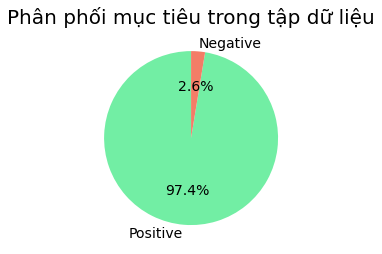

In [205]:
# Tạo biểu đồ hình tròn hiển thị phân phối mục tiêu trong tập dữ liệuplt.figure(figsize=(9, 9))
s = data['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, fontsize=14, colors=['#72EEA4', '#F37D67']);
s.set_ylabel('');
s.set_title('Phân phối mục tiêu trong tập dữ liệu', fontsize=20);

In [206]:
def generate_ngrams(text, n_gram=1):
    """
    Returns ngrams for the given text.
    
    Parameters:
    text : for which we want ngrams
    n_gram : value for ngram
    """
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

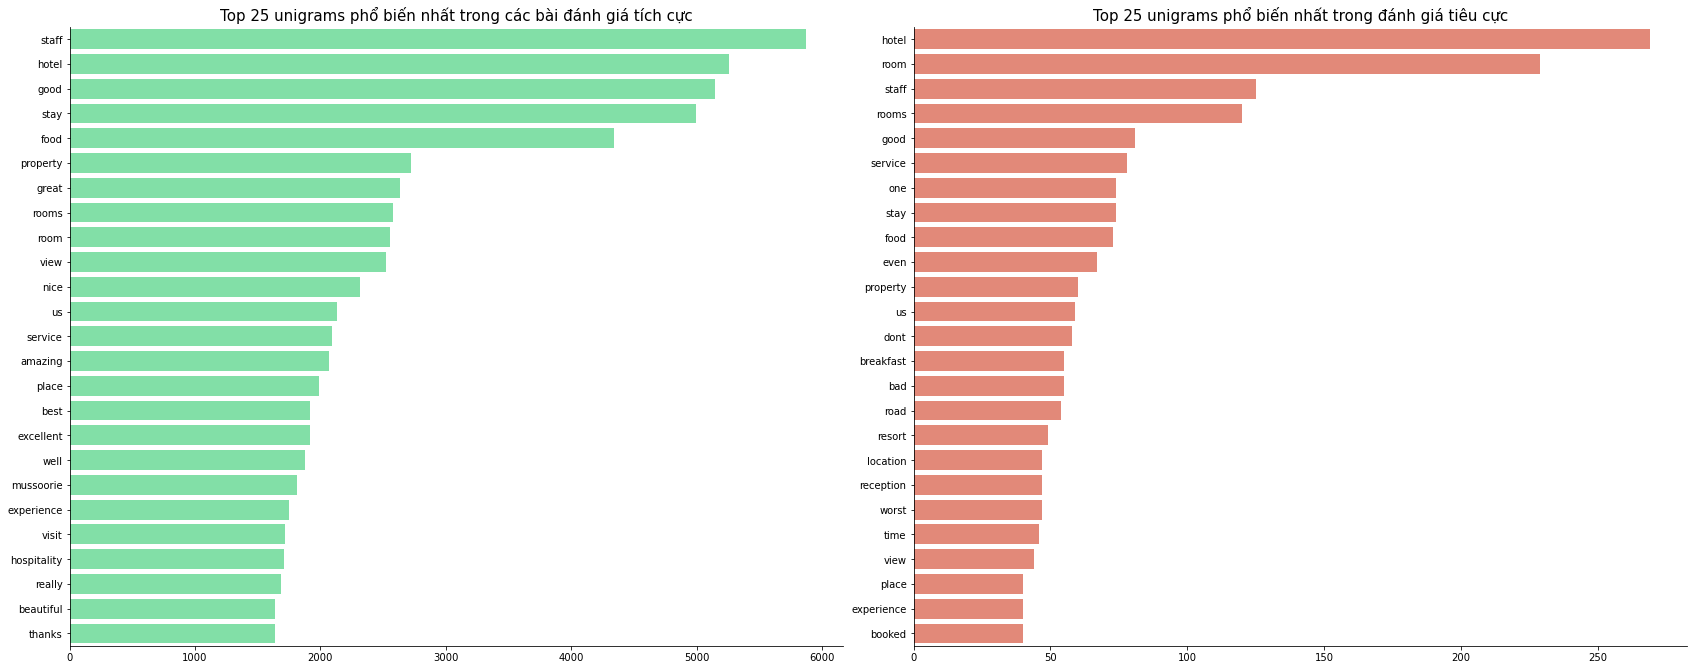

In [207]:
# Tạo từ điển mặc định cho các đơn vị âm dương và âm
positive_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Số ngram chúng tôi muốn
N = 25

# Vòng lặp để cập nhật giá trị của positive_unigram
for review in data['Preprocessed_reviews'][data['Sentiment']=="Positive"]:
    for word in generate_ngrams(review):
        positive_unigrams[word] += 1

for review in data['Preprocessed_reviews'][data['Sentiment']=="Negative"]:
    for word in generate_ngrams(review):
        negative_unigrams[word] += 1
        
# Tạo khung dữ liệu bằng từ điển mặc định
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])

        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)

# Lập biểu đồ tập dữ liệu unigram tích cực và tiêu cực
sns.despine()
sns.barplot(y = df_positive_unigrams[0].values[:N], x = df_positive_unigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_unigrams[0].values[:N], x = df_negative_unigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} unigrams phổ biến nhất trong các bài đánh giá tích cực', fontsize=15)
axes[1].set_title(f'Top {N} unigrams phổ biến nhất trong đánh giá tiêu cực', fontsize=15)

plt.show()


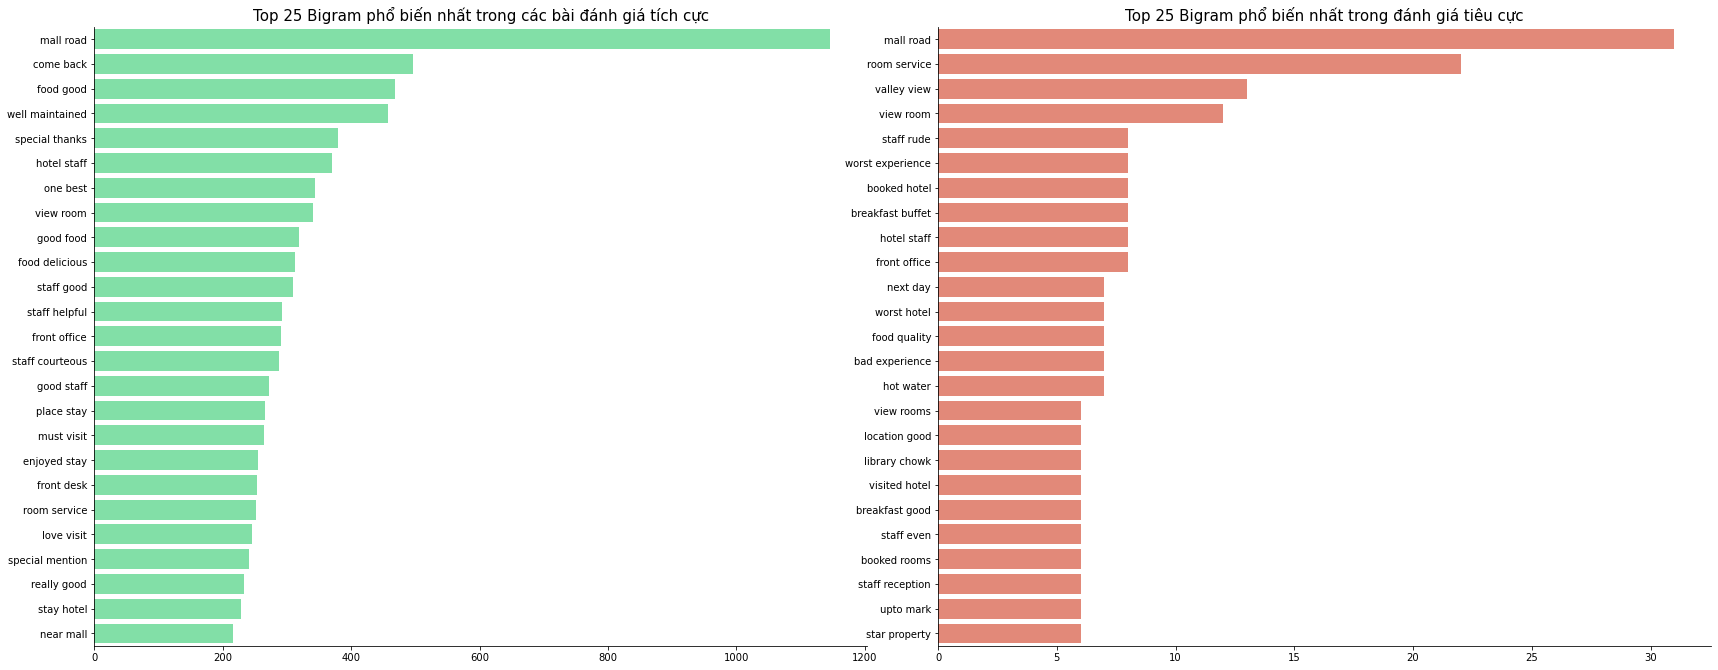

In [208]:
# Tạo từ điển mặc định cho bigram dương và âm
positive_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

# Số ngram chúng tôi muốn
N = 25

# Vòng lặp để cập nhật giá trị của bigram trong từ điển mặc định
for review in data['Preprocessed_reviews'][data['Sentiment']=="Positive"]:
    for word in generate_ngrams(review, n_gram=2):
        positive_bigrams[word] += 1

for review in data['Preprocessed_reviews'][data['Sentiment']=="Negative"]:
    for word in generate_ngrams(review, n_gram=2):
        negative_bigrams[word] += 1
        
# Tạo tập dữ liệu bằng từ điển mặc định
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
 
# Vẽ biểu đồ cả tích cực và tiêu cực
sns.despine()
sns.barplot(y = df_positive_bigrams[0].values[:N], x = df_positive_bigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_bigrams[0].values[:N], x = df_negative_bigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} Bigram phổ biến nhất trong các bài đánh giá tích cực', fontsize=15)
axes[1].set_title(f'Top {N} Bigram phổ biến nhất trong đánh giá tiêu cực', fontsize=15)

plt.show()

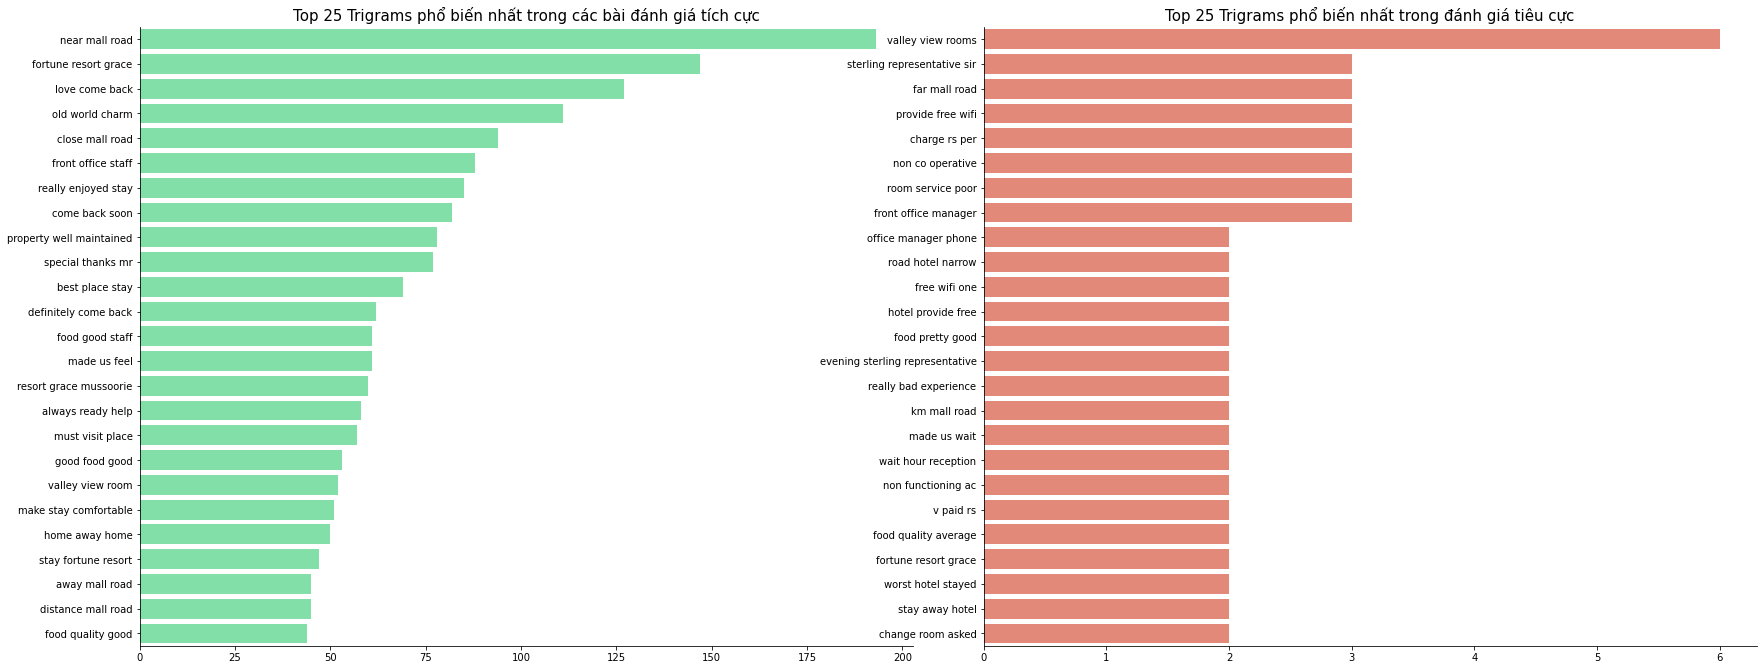

In [209]:
# Tạo từ điển mặc định cho bát quái âm và dương
positive_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

# Số ngram chúng tôi muốn
N = 25

# Vòng lặp để cập nhật từ điển mặc định
for review in data['Preprocessed_reviews'][data['Sentiment']=="Positive"]:
    for word in generate_ngrams(review, n_gram=3):
        positive_trigrams[word] += 1

for review in data['Preprocessed_reviews'][data['Sentiment']=="Negative"]:
    for word in generate_ngrams(review, n_gram=3):
        negative_trigrams[word] += 1
        
# Tạo khung dữ liệu bằng từ điển
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
     
# Mưu đồ Trigrams 
sns.despine()
sns.barplot(y = df_positive_trigrams[0].values[:N], x = df_positive_trigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_trigrams[0].values[:N], x = df_negative_trigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} Trigrams phổ biến nhất trong các bài đánh giá tích cực', fontsize=15)
axes[1].set_title(f'Top {N} Trigrams phổ biến nhất trong đánh giá tiêu cực', fontsize=15)

plt.show()

Nhìn vào những ô ngram này, chúng ta có thể dễ dàng nhận ra đâu là những từ tích cực nhất và tiêu cực nhất được sử dụng trong các bài đánh giá.

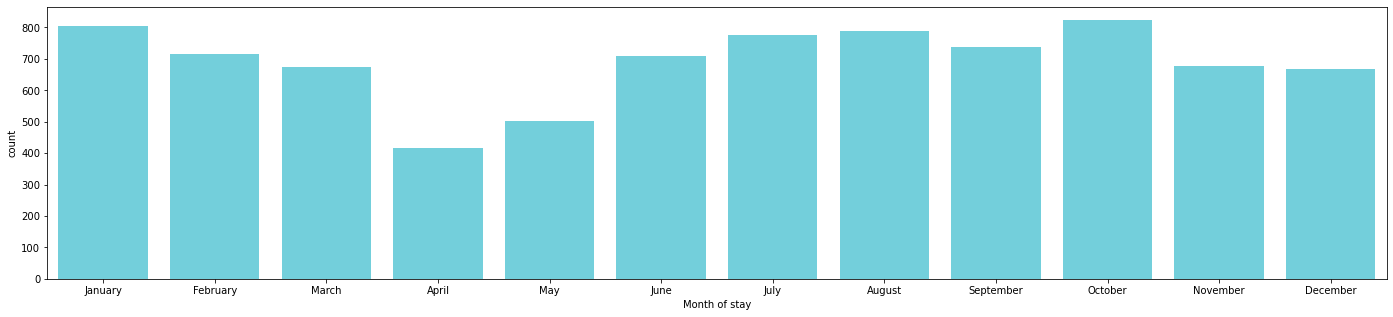

In [210]:
# Lập sơ đồ số lượng đánh giá trong mỗi tháng
plt.figure(figsize = (24, 5))
month =['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.despine()
sns.countplot(x="Month of stay", data=data, order=month, color='#62DCEC');

Tháng 1 và tháng 10 có số lượt đánh giá cao nhất nên có thể nói rằng số lượng người ở lại khách sạn trong tháng này nhiều hơn so với các tháng khác. Tháng 4 có số lượng đánh giá thấp nhất.

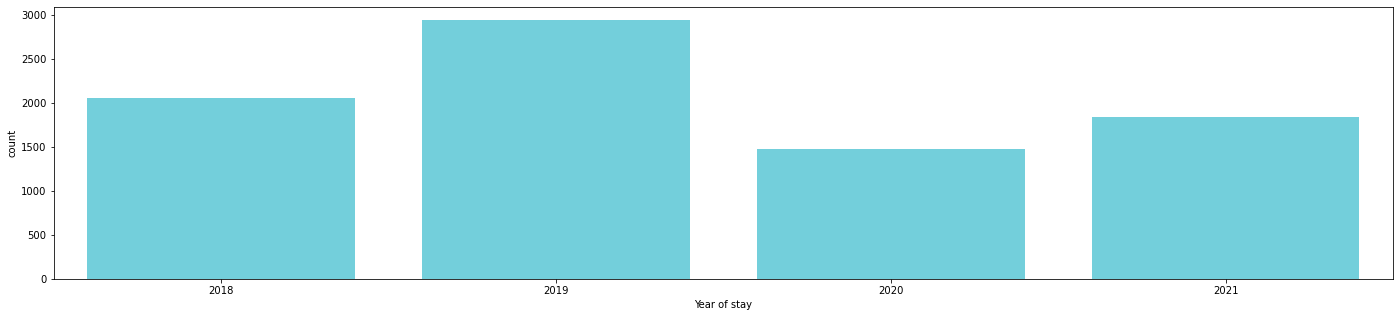

In [211]:
# Lập sơ đồ số lượng đánh giá cho mỗi năm
plt.figure(figsize = (24, 5))
years = ['2018', '2019', '2020', '2021']
sns.despine()
sns.countplot(x="Year of stay", data=data, order=years, color='#62DCEC');

Năm 2019 có số lượng đánh giá cao nhất trong khi năm 2020 có số lượng đánh giá thấp nhất vì đại dịch toàn cầu.

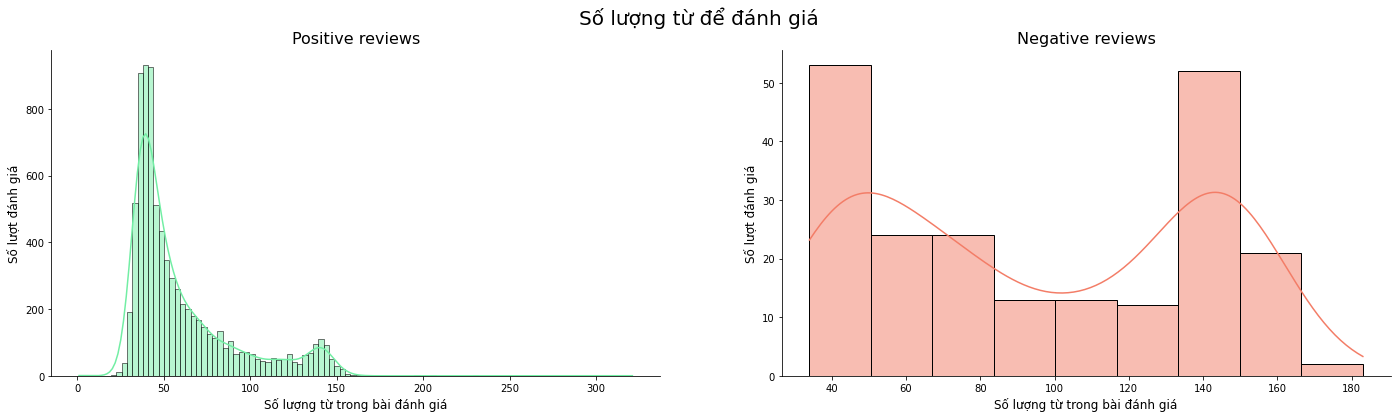

In [212]:
# Lập kế hoạch đếm từ cho các bài đánh giá
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Word_count", data=data[data['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Word_count", data=data[data['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[1].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[0].set_xlabel("Số lượng từ trong bài đánh giá", fontsize=12)
axes[1].set_xlabel("Số lượng từ trong bài đánh giá", fontsize=12)

fig.suptitle("Số lượng từ để đánh giá", fontsize=20)
plt.show()

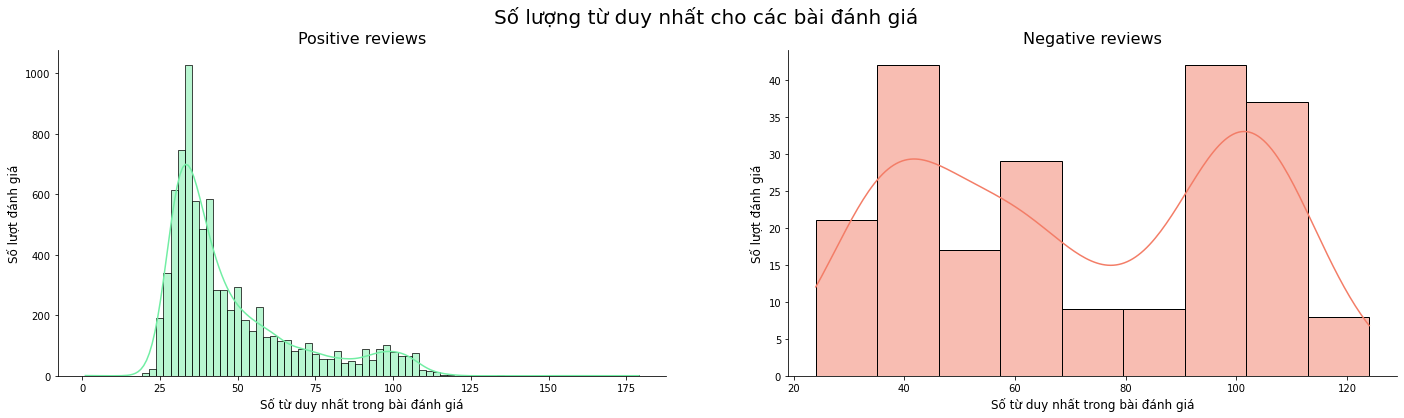

In [213]:
# Lập kế hoạch đếm từ duy nhất cho các bài đánh giá
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Unique_word_count", data=data[data['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Unique_word_count", data=data[data['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[1].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[0].set_xlabel("Số từ duy nhất trong bài đánh giá", fontsize=12)
axes[1].set_xlabel("Số từ duy nhất trong bài đánh giá", fontsize=12)

fig.suptitle("Số lượng từ duy nhất cho các bài đánh giá", fontsize=20)
plt.show()

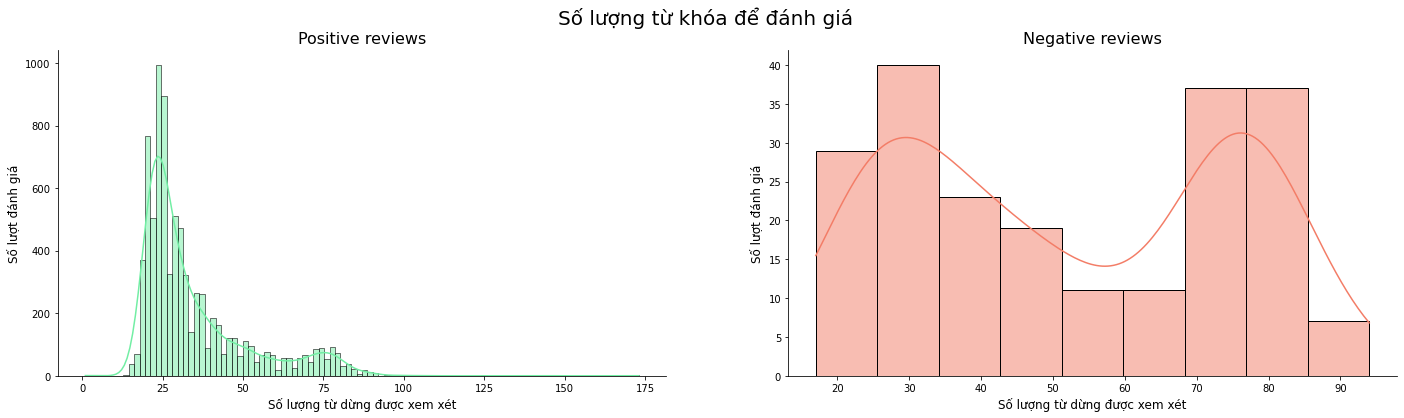

In [214]:
# Lập đồ thị số lượng từ khóa cho các bài đánh giá
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Stopword_count", data=data[data['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Stopword_count", data=data[data['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[1].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[0].set_xlabel("Số lượng từ dừng được xem xét", fontsize=12)
axes[1].set_xlabel("Số lượng từ dừng được xem xét", fontsize=12)

fig.suptitle("Số lượng từ khóa để đánh giá", fontsize=20)
plt.show()

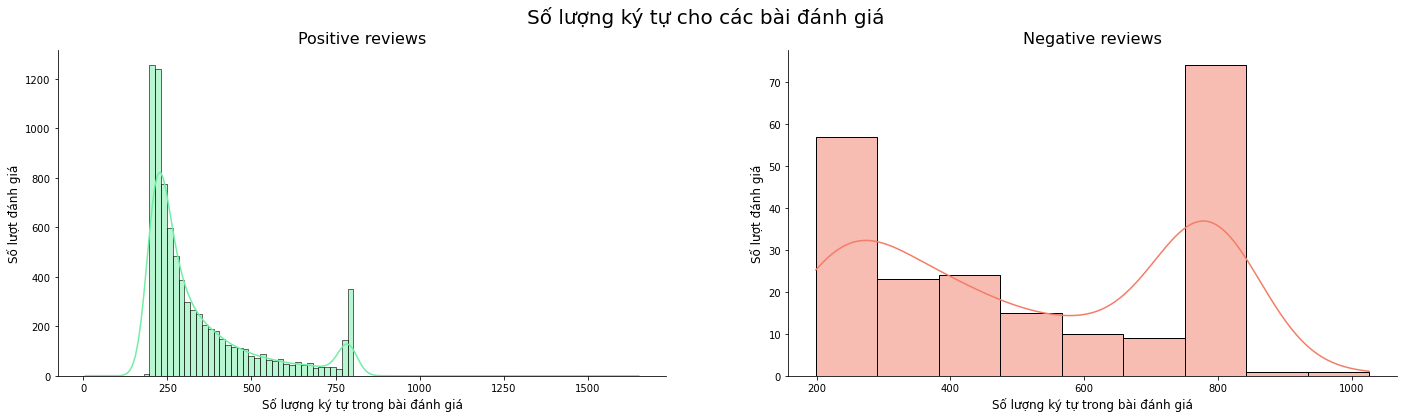

In [215]:
# Lập đồ thị số lượng ký tự cho các bài đánh giá
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Char_count", data=data[data['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Char_count", data=data[data['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[1].set_ylabel("Số lượt đánh giá", fontsize=12)
axes[0].set_xlabel("Số lượng ký tự trong bài đánh giá", fontsize=12)
axes[1].set_xlabel("Số lượng ký tự trong bài đánh giá", fontsize=12)

fig.suptitle("Số lượng ký tự cho các bài đánh giá", fontsize=20)
plt.show()

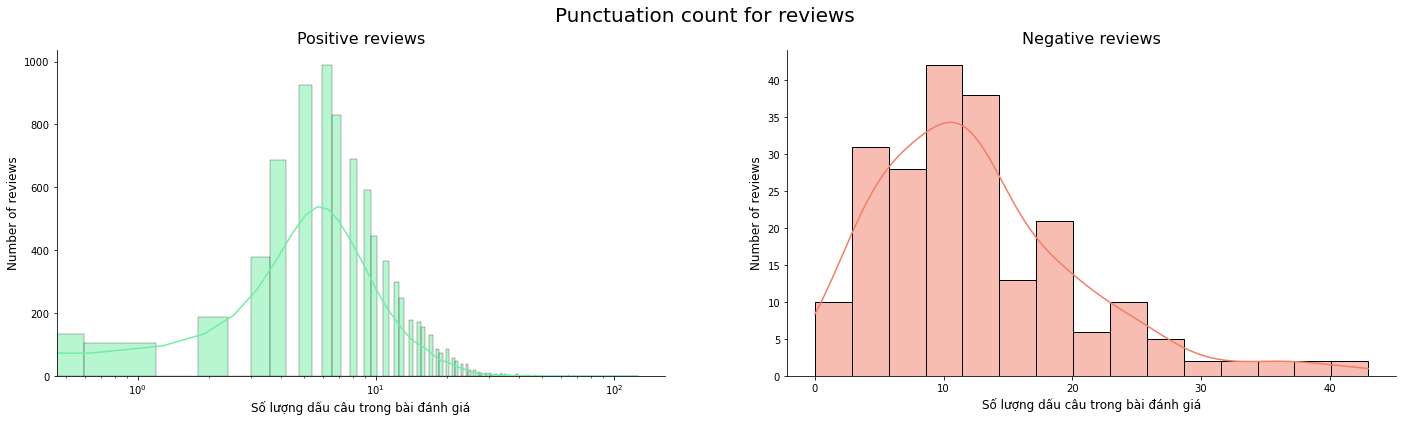

In [216]:
# Đánh dấu số lượng dấu câu cho các bài đánh giá
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Punctuation_count", data=data[data['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Punctuation_count", data=data[data['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)
axes[0].set_xscale('log')

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Số lượng dấu câu trong bài đánh giá", fontsize=12)
axes[1].set_xlabel("Số lượng dấu câu trong bài đánh giá", fontsize=12)

fig.suptitle("Punctuation count for reviews", fontsize=20)
plt.show()

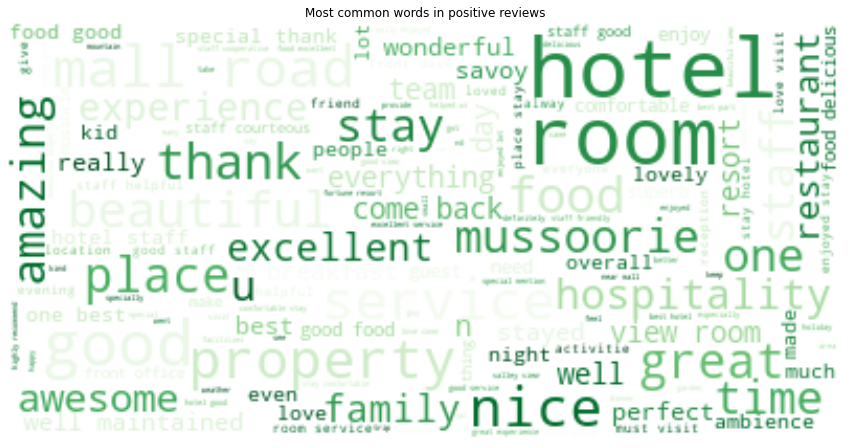

In [217]:
# Lập kế hoạch cho một wordcloud để có những đánh giá tích cực
positive = " ".join(review for review in data['Preprocessed_reviews'][data['Sentiment']=="Positive"])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=40, random_state=42, colormap='Greens').generate(positive)
plt.figure(figsize=(15, 10))
plt.title("Most common words in positive reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

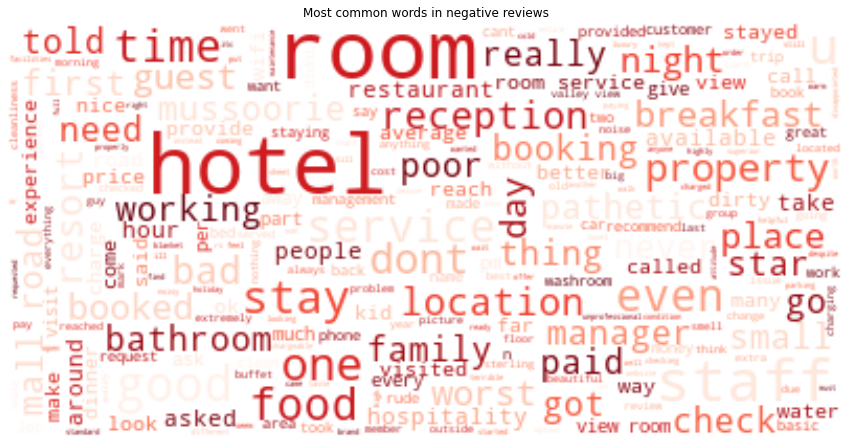

In [218]:
# Lập kế hoạch wordcloud cho các đánh giá tiêu cực
negative = " ".join(review for review in data['Preprocessed_reviews'][data['Sentiment']=="Negative"])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=40, random_state=42, colormap = "Reds").generate(negative)
plt.figure(figsize=(15, 10))
plt.title("Most common words in negative reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [219]:
# Tạo các từ dừng tùy chỉnh
all_text = " ".join(list(data["Preprocessed_reviews"]))
words = pd.Series(all_text.split(" "))
frequent_words = words.value_counts()[:20]

In [220]:
# Xóa 10 từ thường gặp nhất khỏi preprocessed_reviews
data["Preprocessed_reviews"] = data["Preprocessed_reviews"].apply(lambda x: " ".join([word for word in str(x).split() if word not in frequent_words]))

In [221]:
# Sử dụng bộ mã hóa nhãn để mã hóa cột tình cảm
le = LabelEncoder()
data['Sentiment'] = le.fit_transform(data['Sentiment'])

In [222]:
# Tách tập dữ liệu thành tập dữ liệu đào tạo và kiểm tra
xtrain, xtest, ytrain, ytest = train_test_split(data['Hcomment'], data['Sentiment'], 
                                                  stratify=data['Sentiment'], 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [223]:
# Tách tập dữ liệu đào tạo thành tập dữ liệu đào tạo và xác nhận
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
                                                  stratify=ytrain, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

# Mô hình training

In [224]:
# Khởi tạo TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, decode_error = "replace", preprocessor = preprocess_data,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Lắp vectorizer Tfidf vào tập dữ liệu đào tạo
tfv.fit(list(xtrain))

# Transforming the training and validation dataset 
xtrain_tfv = tfv.transform(xtrain)
xval_tfv = tfv.transform(xval)

In [225]:
# Khởi tạo XGBClassifier
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8, random_state=42)

# Phù hợp xgb trên tập dữ liệu đào tạo
xgb.fit(xtrain_tfv, ytrain)

# Đưa ra dự đoán trên tập dữ liệu xác thực
predictions = xgb.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

ypred_xg = xgb.predict(xval_tfv)
print(classification_report(yval, ypred_xg))

logloss: 0.047 
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        17
           1       0.99      1.00      0.99       647

    accuracy                           0.99       664
   macro avg       0.99      0.76      0.84       664
weighted avg       0.99      0.99      0.99       664



XGBClassifier đưa ra logloss: 0.047, điểm F1 cho các đánh giá tiêu cực là 0,79 và cho các đánh giá tích cực là 1.

# Mô hình đánh giá- Model evaluation

In [226]:
# Chuyển đổi tập dữ liệu văn bản bằng cách sử dụng cùng một trình tfidfvectorizer từ tập dữ liệu đào tạo xtest_tfv = tfv.transform(xtest)

In [227]:
# Đưa ra dự đoán trên tập dữ liệu thử nghiệm
predictions = xgb.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % log_loss(ytest, predictions))
ypred_xg = xgb.predict(xtest_tfv)
print(classification_report(ytest, ypred_xg))

logloss: 0.044 
              precision    recall  f1-score   support

           0       0.86      0.42      0.56        43
           1       0.98      1.00      0.99      1616

    accuracy                           0.98      1659
   macro avg       0.92      0.71      0.78      1659
weighted avg       0.98      0.98      0.98      1659



Đối với tập dữ liệu thử nghiệm, chúng tôi nhận được logloss: 0.044 và điểm F1 cho các đánh giá tiêu cực là 0,55 và cho các đánh giá tích cực là 0,99.